# Prepare the environment

In [1]:
from matplotlib import rcParams

rcParams["savefig.dpi"] = 120
rcParams["figure.dpi"] = 120
#rcParams["font.size"] = 20

In the following tutorial, we will use **pyodine** to compute RVs from SONG spectra for the star $\sigma$~Draconis. This includes three basic steps:

- using I2-free observations of the star, plus B-star spectra *with* the I2 cell, to [create a deconvolved stellar template](./template.ipynb);

- with that template, [modelling the I2 observations](./observation.ipynb) of the star to arrive at best-fit parameters (including, most importantly, the chunk velocities);

- [weighting and combining the chunk velocities](./velocities.ipynb) to compute the RV timeseries of the observations.

In each of these steps, we will present how to use built-in methods of **pyodine** to visualize and analyze the results.

But, first of all, we will take a quick look at some basic modules of **pyodine** and its usage to develop a better understanding.

One possibility to use **pyodine** from any location in your filesystem is by appending its root path to the Python system path, and then import it like this (make sure to use the full **pyodine** path on your own machine when you try this):

In [7]:
import sys

# pyodine path on the machine
pyodine_path = '/home/paul/pyodine'

sys.path.append(pyodine_path)

import pyodine

In the following, we will use some capabilities of **pyodine** to examine the I2 atlas and the utilities module.

## The I2 atlas

The I2 atlasses in **pyodine** are stored as HDF5 files. If you want to use pyodine for your own project with a new I2 atlas, you need to bring it into the correct HDF5-format (find out more about [HDF5/h5py](http://www.h5py.org/)). Here, we will have a look at the SONG I2 atlas to see how it is built up.

We use functions contained in `pyodine.lib.h5quick` to print information about the I2 atlas: `h5print` to show the structure of the HDF5 file/h5py object, and `h5data` to load the wavelength and flux vectors needed in the later modelling.

In [8]:
from pyodine.lib.h5quick import h5print, h5data
import h5py

# the path to the I2 atlas
I2_path = pyodine_path + '/iodine_atlas/song_iodine_cell_01_65C.h5'

h = h5py.File(I2_path, 'r')
h5print(h)

flux_normalized = h5data(h['flux_normalized'])
wavelength_air  = h5data(h['wavelength_air'])

print('\nLength of the wavelength/flux vectors:', len(wavelength_air))
print('\nFull wavelength range (air): {:.3f} - {:.3f} Angstrom'.format(
    wavelength_air[0], wavelength_air[-1]))

/
└ flux
└ flux_normalized
└ wavelength
└ wavelength_air
└ wavenumber

Length of the wavelength/flux vectors: 618003

Full wavelength range (air): 4988.607 - 6498.200 Angstrom


As you can see, the I2 atlas contains the wavelength range between roughly 4989 and 6498 Å - that is in air, which is used in the SONG implementation (in vacuum the wavelengths would be slightly different).

Now let's plot the normalized flux of the I2 atlas, over the whole range and in a subset to make the many narrow lines visible:

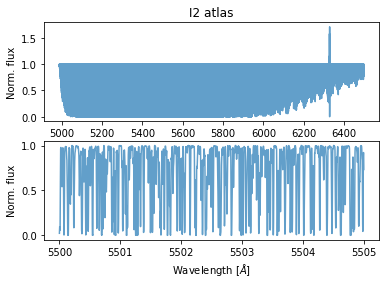

In [9]:
# Required packages
import matplotlib.pyplot as plt
import numpy as np

# Subset wavelengths
ind = np.where(np.logical_and(wavelength_air>5500., wavelength_air<5505.))

# Plot
fig, axs = plt.subplots(2)
axs[0].set_title('I2 atlas')
axs[0].plot(wavelength_air, flux_normalized, alpha=0.7)
axs[1].plot(wavelength_air[ind], flux_normalized[ind], alpha=0.7)
axs[1].set_xlabel(r'Wavelength [$\AA$]')
axs[0].set_ylabel('Norm. flux')
axs[1].set_ylabel('Norm. flux')
plt.show()

## The utilities module

All instrument- or user-specific code is contained within the utilities modules - e.g. ``utilities_song`` or ``utilities_lick`` for the SONG and Lick instrument, respectively. Here sits code that defines e.g. how to load spectra from the disc, or that contains the important run parameters for the I2 cell code.

Again, we just use the existing ``utilities_song`` module to understand it: Let's import the ``utilities_song.pyodine_parameters`` module and see what is inside:

In [10]:
import utilities_song.pyodine_parameters as pyodine_parameters

help(pyodine_parameters)

Help on module utilities_song.pyodine_parameters in utilities_song:

NAME
    utilities_song.pyodine_parameters

DESCRIPTION
    Set here all the important parameters for the I2 reduction pipeline, both
    modeling of individual observations as well as the template creation.
    
    Paul Heeren, 3/02/2021

CLASSES
    builtins.object
        Parameters
        Template_Parameters
    
    class Parameters(builtins.object)
     |  The control commands for the main routine
     |  
     |  The exact details of the algorithm are defined entirely by the parameters
     |  in this class: Parameters for chunk creation, general model parameters,
     |  and details about how many runs are used in the modelling and which LSF
     |  models are employed (and more).
     |  
     |  Furthermore, in the class method :method:`constrain_parameters` you can
     |  specify and alter input parameter descriptions for the model, e.g. set
     |  bounds or fix parameters.
     |  
     |  Methods defi

So, let's initiate a ``Template_Parameters`` object. It contains a large number of instance variables, a few of which we will print here (to see all, just open the Python file in an editor):

In [11]:
Pars = pyodine_parameters.Template_Parameters()

print('Oversampling of the model: ', Pars.osample_obs)
print('Orders of the spectra to use: ', Pars.temp_order_range)
print('Chunk width: ', Pars.chunk_width)
print('Model parameters (run 0):\n', Pars.model_runs[0])

Oversampling of the model:  6
Orders of the spectra to use:  (18, 41)
Chunk width:  91
Model parameters (run 0):
 {'lsf_model': <class 'pyodine.models.lsf.SingleGaussian'>, 'pre_wave_slope_deg': 3, 'pre_wave_intercept_deg': 3, 'use_chauvenet_pixels': True, 'save_result': True, 'save_filetype': 'h5py', 'wave_slope_deg': 3, 'wave_intercept_deg': 3, 'plot_success': True, 'plot_analysis': True, 'plot_chunks': [150, 250, 400], 'plot_lsf_pars': True, 'save_median_pars': True}


So, if you want to adapt **pyodine** to a new instrument, you need to incorporate this module with all required variables. Best is then, you simply copy-paste an existing utilities module - e.g. ``utilities_song`` - and then just change the parameters as needed.

The same obviously goes for code which defines the loading of spectra from disk - for the SONG instrument, this resides in the module ``utilities_song.load_pyodine``. Again you could use the ``help()`` function to get the full picture of it - here we just look at the most important class there, which is the ``ObservationWrapper``. Each and every observation gets loaded from file into an object of this type:

In [12]:
import utilities_song.load_pyodine as load

print(load.ObservationWrapper.__name__)
print(load.ObservationWrapper.__doc__)

ObservationWrapper
A wrapper for the representation of SONG observation spectra
    
    :param filename: The filename of the observation to load.
    :type filename: str
    :param instrument: The instrument used to obtain the observation. If None,
        the information is drawn from the Fits-header (default).
    :type instrument: :class:`Instrument`
    :param star: The star of the observation. If None, the information is 
        drawn from the Fits-header (default).
    :type star: :class:`Star`
    
